In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [2]:
# Load drone data
df = pd.read_csv("uav_logs.csv")

# Quick look at data
df.head()


,timestamp,department,authorized_use_select_all,drone_make_model,faa_provided_drone,street_address_area_surveyed,faa_provided_commercial_pilot,location_area_surveyed,start_date,start_time,end_date,end_time,type_of_data_collected,privacy_risks_summary_of,privacy_risk_mitigation_action,summary_description_of_flight
0,2020/03/04 3:18:40 PM AST,ITS Information & Technology Services,"Training: Preplanning, assessment and evaluati...",DJI Spark,FA3EE79T9M,1001 S Henderson St (Bryan Park),2371017.0,Bryan Park,2020-03-04T00:00:00.000,15:00,2020-03-04T00:00:00.000,17:00,Images;Video,NaN,NaN,NaN
1,2020/03/04 3:44:53 PM AST,ITS Information & Technology Services,Inspections: Surveys and assessments of proper...,DJI Spark,FA3EE79T9M,N Dunn Street (Griffy Water Treatment Plant),2371017.0,Griffy Water Treatment Plant,2020-03-05T00:00:00.000,13:30,2020-03-05T00:00:00.000,17:00,Images;Video,NaN,NaN,NaN
2,2020/05/07 12:24:34 PM AST,ITS Information & Technology Services,Marketing: Capture video and still photographs.,DJI Mavic 2,FA39YEE7AK,2851 Old State Rd 37,4364237.0,Lower Cascades park,2020-05-07T00:00:00.000,11:30,2020-05-07T00:00:00.000,12:05,Video,People walking through the park,Do not show faces of any member of the public ...,Promotional video footage of Lower Cascades Park
3,2020/05/07 12:27:22 PM AST,ITS Information & Technology Services,Inspections: Surveys and assessments of develo...,DJI Mavic 2,FA39YEE7AK,300 E 4th Street,4364237.0,Downtown (From 4th & Grant to 2nd & Washington),2020-05-07T00:00:00.000,14:00,2020-05-07T00:00:00.000,15:00,Video,Video of members of the public,Do not show faces of members of the public in ...,Aerial survey of proposed improvements to stor...
4,2020/05/18 9:35:21 AM AST,ITS Information & Technology Services,Marketing: Capture video and still photographs.,DJI Mavic 2,FA39YEE7AK,1150 W. Guy McCown Drive\nClosest cross street...,4364237.0,Ellettsville Town Hall,2020-05-20T00:00:00.000,14:45,2020-05-20T00:00:00.000,15:30,Images;Video,Members of the public,Members of the public faces will not be recorded,Video footage of emergency responder vehicles ...


In [3]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   timestamp                       77 non-null     object 
 1   department                      77 non-null     object 
 2   authorized_use_select_all       77 non-null     object 
 3   drone_make_model                77 non-null     object 
 4   faa_provided_drone              71 non-null     object 
 5   street_address_area_surveyed    77 non-null     object 
 6   faa_provided_commercial_pilot   71 non-null     float64
 7   location_area_surveyed          76 non-null     object 
 8   start_date                      77 non-null     object 
 9   start_time                      77 non-null     object 
 10  end_date                        77 non-null     object 
 11  end_time                        77 non-null     object 
 12  type_of_data_collected          76 non

timestamp                         0
department                        0
authorized_use_select_all         0
drone_make_model                  0
faa_provided_drone                6
street_address_area_surveyed      0
faa_provided_commercial_pilot     6
location_area_surveyed            1
start_date                        0
start_time                        0
end_date                          0
end_time                          0
type_of_data_collected            1
privacy_risks_summary_of          8
privacy_risk_mitigation_action    8
summary_description_of_flight     5
dtype: int64

In [4]:
# Convert any column containing 'date' or 'time' to datetime
for col in df.columns:
    if 'date' in col.lower() or 'time' in col.lower():
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Example: create numeric features from start_date and start_time
if 'start_date' in df.columns and 'start_time' in df.columns:
    df['flight_datetime'] = df['start_date'] + pd.to_timedelta(df['start_time'].dt.hour, unit='h') \
                                          + pd.to_timedelta(df['start_time'].dt.minute, unit='m')
    df['flight_hour'] = df['start_time'].dt.hour
    df['flight_dayofweek'] = df['start_date'].dt.dayofweek

# Optional: calculate flight duration in minutes
if 'start_datetime' not in df.columns:
    df['start_datetime'] = df['start_date'] + pd.to_timedelta(df['start_time'].dt.hour, unit='h') + pd.to_timedelta(df['start_time'].dt.minute, unit='m')
if 'end_datetime' not in df.columns and 'end_date' in df.columns and 'end_time' in df.columns:
    df['end_datetime'] = df['end_date'] + pd.to_timedelta(df['end_time'].dt.hour, unit='h') + pd.to_timedelta(df['end_time'].dt.minute, unit='m')

df['flight_duration_min'] = (df['end_datetime'] - df['start_datetime']).dt.total_seconds() / 60


C:\Users\ianco\AppData\Local\Temp\ipykernel_9504\4019305008.py:4: FutureWarning: Parsed string "2020/03/04 3:18:40 PM AST" included an un-recognized timezone "AST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\ianco\AppData\Local\Temp\ipykernel_9504\4019305008.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')
C:\Users\ianco\AppData\Local\Temp\ipykernel_9504\4019305008.py:4: FutureWarning: Parsed string "2020/03/04 3:44:53 PM AST" included an un-recognized timezone "AST". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timez

In [5]:
# Drop rows with missing values in numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())


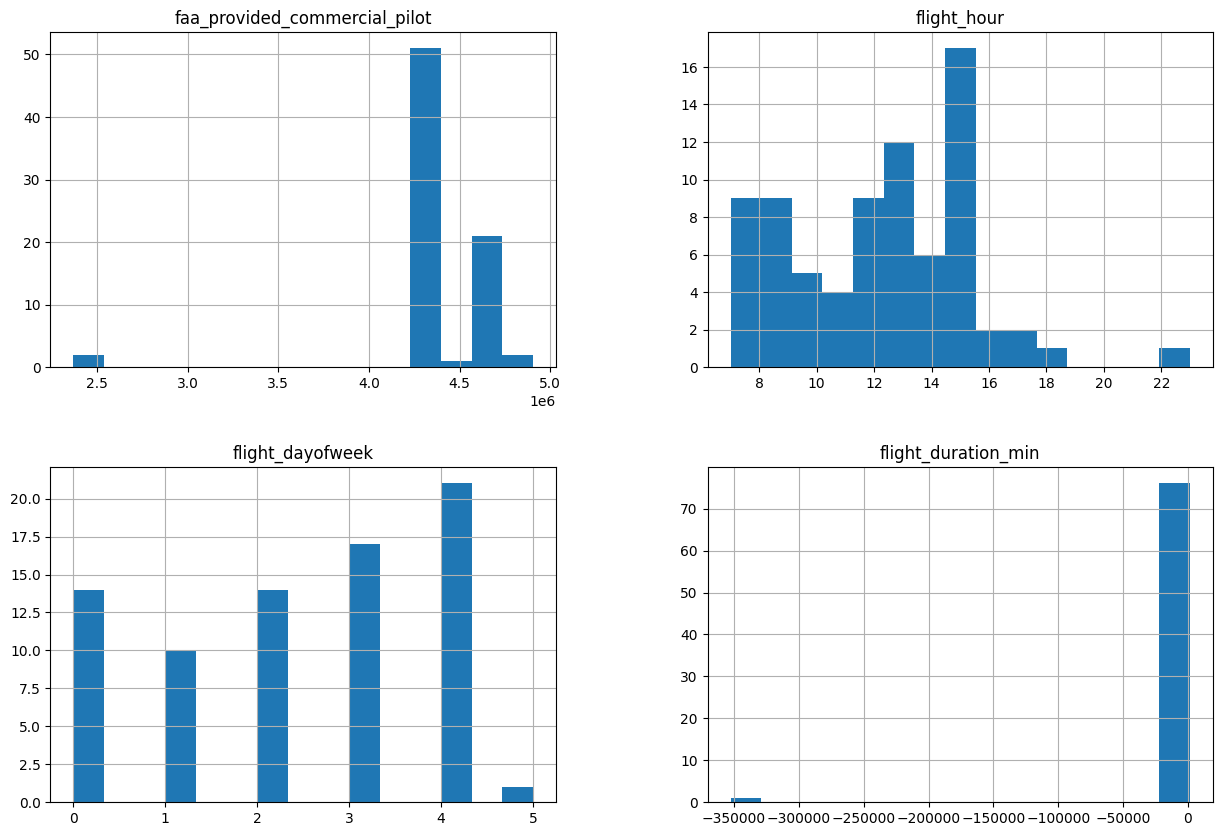

In [6]:
# Descriptive statistics
df.describe()

# Histogram of numeric columns
df[numeric_cols].hist(bins=15, figsize=(15,10))
plt.show()


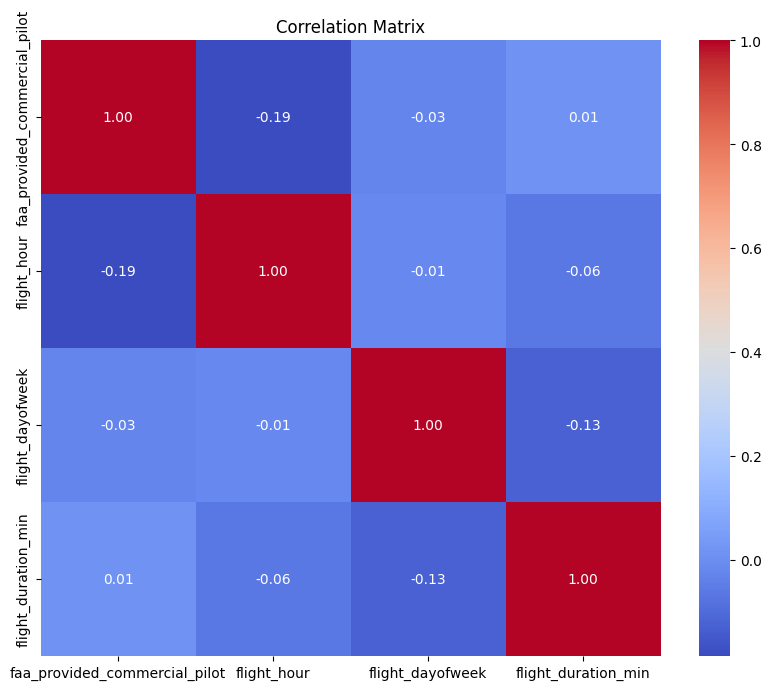

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


Explained variance by component:
 [0.30268436 0.27690949 0.22388571 0.19652045]


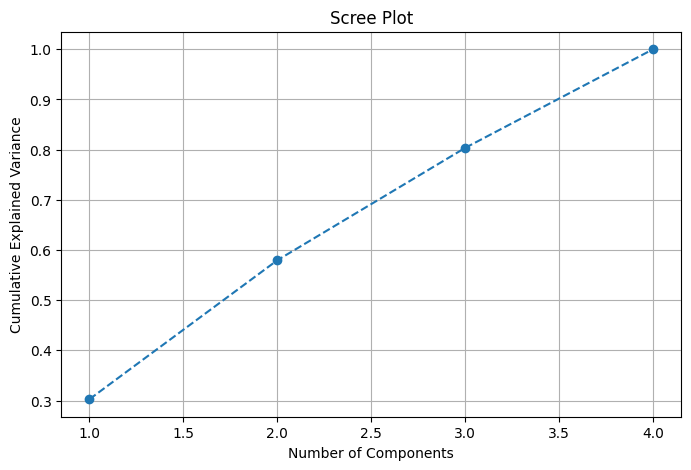

In [ ]:
# Standardize numeric columns
scaled_data = StandardScaler().fit_transform(df[numeric_cols])

# Fit PCA
pca = PCA()
pca_components = pca.fit_transform(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
print("Explained variance by component:\n", explained_variance)

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Screen Plot")
plt.grid()
plt.show()


                                    PC1       PC2       PC3       PC4
faa_provided_commercial_pilot -0.611083  0.333728 -0.422391  0.580336
flight_hour                    0.634853 -0.320973 -0.296731  0.637094
flight_dayofweek               0.273114  0.665418  0.603474  0.344161
flight_duration_min           -0.385938 -0.585510  0.607747  0.372658


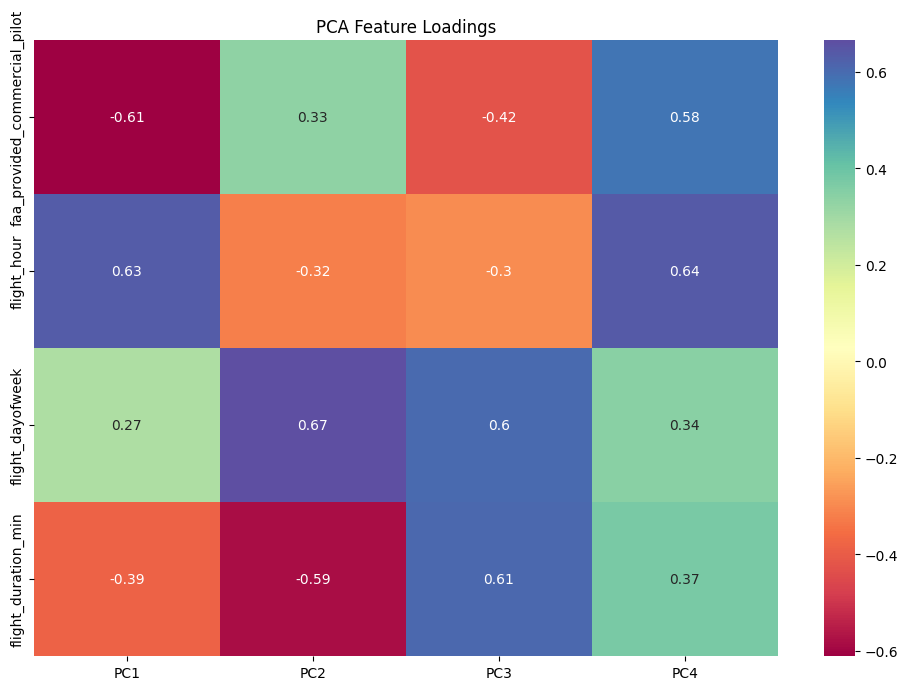

In [9]:
# Get feature contributions (loadings)
loadings = pd.DataFrame(
    pca.components_.T,
    index=numeric_cols,
    columns=[f'PC{i+1}' for i in range(len(numeric_cols))]
)
print(loadings)

# Visualize loadings
plt.figure(figsize=(12,8))
sns.heatmap(loadings, annot=True, cmap='Spectral')
plt.title("PCA Feature Loadings")
plt.show()


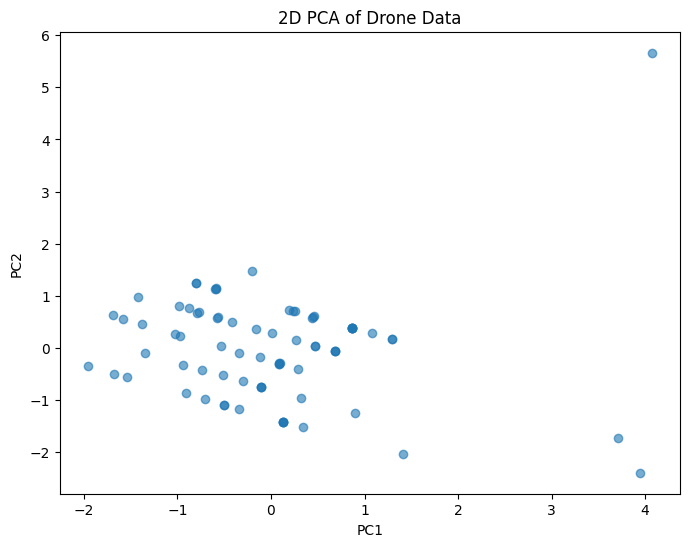

In [10]:
# Reduce to 2 components for visualization
pca_2 = PCA(n_components=min(2, len(numeric_cols)))  # avoid error if <2 numeric features
pca_2_data = pca_2.fit_transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(pca_2_data[:,0], pca_2_data[:,1], alpha=0.6)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA of Drone Data")
plt.show()


In [11]:
print("Conclusions:")
print("- Look at the loadings heatmap to see which features contribute most to variance.")
print("- Scree plot tells how many components explain most of the variance (e.g., 80–90%).")
print("- 2D PCA plot can show potential clusters or patterns in the drone data.")


Conclusions:
- Look at the loadings heatmap to see which features contribute most to variance.
- Scree plot tells how many components explain most of the variance (e.g., 80–90%).
- 2D PCA plot can show potential clusters or patterns in the drone data.
